# **Problem 2 Knn & Adaboost (13 points) [TA: Vodelina Samatova]**

In this part, you'll be working with KNN and AdaBoost. 

## Instructions:
1. Use github.ncsu.edu to submit your work repository if you have not done so yet. It is your responsbility to ensure the TAs have access to your work before the deadline.
2. Do not modify the code structure given. Answer the questions in the designated space.

All the best!

# 0) Loading Data & Libraries

In [1]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets

# set a seed for reproducibility
random_seed = 25
np.random.seed(random_seed)

# We need to ignore FutureWarnings due to a bug in our version of sklearn
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# 1) YouTube Sentiment Analysis using KNN

[Sentiment analysis](https://en.wikipedia.org/wiki/Sentiment_analysis) is the study of how we can systematically identify and quantify sentiment of a given segment of text. In this problem, you will be using the [YouTube Statistics](https://www.kaggle.com/datasets/advaypatil/youtube-statistics?select=comments.csv) dataset to build a classifier that will rate the sentiment of a string of text on a scale from 0 to 4.

**WARNING:** This is *real* data from *real* people from YouTube. That means you might (and probably will) see some unscrupulous language when browsing the dataset. Don't browse with kids around!

Let's take a look at our data, and what attributes we have.

* **Video ID**: The Video Identifier.
* **Comment**: The comment text.
* **Likes**: The number of likes the comment received.
* **Sentiment**: The sentiment of the comment. A value of 0 represents a negative sentiment, while values of 1 or 2 represent neutral and positive sentiments respectively.

For now, we only consider the **Comment** and **Sentiment** attributes.ly.

In [2]:
train_data = pd.read_csv('../data/hw2_p2_comments.csv')
train_data.head()

,Unnamed: 0,Video ID,Comment,Likes,Sentiment
0,0,wAZZ-UWGVHI,Let's not forget that Apple Pay in 2014 requir...,95.0,1.0
1,1,wAZZ-UWGVHI,Here in NZ 50% of retailers don’t even have co...,19.0,0.0
2,2,wAZZ-UWGVHI,I will forever acknowledge this channel with t...,161.0,2.0
3,3,wAZZ-UWGVHI,Whenever I go to a place that doesn’t take App...,8.0,0.0
4,4,wAZZ-UWGVHI,"Apple Pay is so convenient, secure, and easy t...",34.0,2.0


In [3]:
# Check our disribution of polarity
# 0 means negative sentiment
# 1 means neutral sentiment
# 2 means positive sentiment
train_data.Sentiment.value_counts()

Sentiment
2.0    11432
1.0     4639
0.0     2338
Name: count, dtype: int64

## 1.1) Example: Brief Introduction to tf-idf

Read through and run the following example, and answer the question at the end.

In information retreival [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) (*term frequency – inverse document frequency*) is a metric that represents how "important" a word is to a corpus of text. While we won't go into detail about how it works, essentially all you need to know is that it balances two metrics.

**Term Frequency**: Is exactly what one would expect, it is the the frequency at which a word is present in a corpus of text. A word with a higher term-frequency score appears much more in the corpus compared to one with a low term frequency.

**Inverse Document Frequency**: If we only used term frequency, common words like "the" or "and" would have a high score, even though they don't give us that much information since they are present in every document. *Inverse Document Frequency* is a metric of how much "information" a word provides, and if a word is common or rare across all documents.

### tf-idf with sklearn

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?'
]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)

#TODO: output the shape of X
X.shape


(4, 9)

The tf-idf vectorizer's `fit_transform` method returns a NxM matrix. `N` is the number of documents (sentences) you have in your corpus, and `M` is the number of unique words in your corpus. Item `n`x`m` is how important word `m` is to document `n`.

In [5]:
# Printing out the tf-idf matrix
np.set_printoptions(precision=4)
print(X.toarray())

[[0.     0.4698 0.5803 0.3841 0.     0.     0.3841 0.     0.3841]
 [0.     0.6876 0.     0.2811 0.     0.5386 0.2811 0.     0.2811]
 [0.5118 0.     0.     0.2671 0.5118 0.     0.2671 0.5118 0.2671]
 [0.     0.4698 0.5803 0.3841 0.     0.     0.3841 0.     0.3841]]


In [6]:
# Notice that if we try and print X directly, we get an overview saying that X is a "sparse matrix".
# In very large corpi with many unique words, a lot of row entries are going to consist of majority zeros
# Thus numpy saves theses in a special compressed sparse format
X

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 21 stored elements and shape (4, 9)>

In [7]:
# Next let's see what word each column corresponds to:
vectorizer.get_feature_names_out()

array(['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third',
       'this'], dtype=object)

Let's look at the tf-idf vectors for two different documents.

**Note**: `dic(zip(A, B))` in pyton makes a dictionary out of a list of keys (A) and values (B). This just makes it easier to view each term with it's corresponding TFIDF value.

In [8]:
print(corpus[0])
dict(zip(vectorizer.get_feature_names_out(),X.toarray()[0]))

This is the first document.


{'and': np.float64(0.0),
 'document': np.float64(0.46979138557992045),
 'first': np.float64(0.5802858236844359),
 'is': np.float64(0.38408524091481483),
 'one': np.float64(0.0),
 'second': np.float64(0.0),
 'the': np.float64(0.38408524091481483),
 'third': np.float64(0.0),
 'this': np.float64(0.38408524091481483)}

In [9]:
print(corpus[1])
dict(zip(vectorizer.get_feature_names_out(),X.toarray()[1]))

This document is the second document.


{'and': np.float64(0.0),
 'document': np.float64(0.6876235979836938),
 'first': np.float64(0.0),
 'is': np.float64(0.281088674033753),
 'one': np.float64(0.0),
 'second': np.float64(0.5386476208856763),
 'the': np.float64(0.281088674033753),
 'third': np.float64(0.0),
 'this': np.float64(0.281088674033753)}

Take a look at the tf-idf vectors for both of these sentences and answer the following questions:
1. Why is the value for the term "is" higher in document1 than document2?
2. Why is the value for the term "document" higher in document2 than document1?

**Answer Here**
1. Although "is" appears in both documents, in document 2 it is used alongside more specific words like "document" and "second." As a result, its contribution to document 2 is diluted. This makes the TF-IDF value for "is" higher in document 1 than in document 2.
2. Even though "document" appears in both documents, the difference in term frequency (TF) causes "document" to have a higher TF-IDF score in document 2 because it appears more frequently in that document compared to document 1.

## 1.2) tf-idf on YouTube Data

Now, before we build a classifier, let's just try and see what the nearest neighbors of a specified message are.

In [10]:
# Get our text
corpus = train_data["Comment"]

In [11]:
# Handle missing values in your corpus
corpus = corpus.dropna()

In [12]:
# Run our transform
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer()
tfidf_matrix = tf.fit_transform(corpus)

In [13]:
# Let's check the size of our matrix
tfidf_matrix

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 469085 stored elements and shape (18408, 35685)>

Now, let's fit the nearest neighbors tree! Please use [NearestNeighbors](https://scikit-learn.org/stable/modules/neighbors.html) from sklearn library

NOTE: fit the nearest neighbors tree (with **five** neighbors) on _**"tfidf_matrx"**_ we got from above, and return the model as _**"nbrs"**_

In [14]:
from sklearn.neighbors import NearestNeighbors
# TODO
nbrs = NearestNeighbors(n_neighbors=5, algorithm='auto').fit(tfidf_matrix)


In [15]:
assert(nbrs.n_features_in_ == 35685)
assert(nbrs.n_samples_fit_ == 18408)
assert(nbrs.get_params()['n_neighbors'] == 5)

We can now run custom sentences and see what sentences in the corpus are "closest" to what we put in. Try a few and see what shows up! In addition to this, you can change the `n_neighbors` param and get more queries.

In [16]:
test_docs = ["I love this comedy movie"]
test_docs = tf.transform(test_docs)

distances, indicies = nbrs.kneighbors(test_docs)
train_data.iloc[indicies[0]]

,Unnamed: 0,Video ID,Comment,Likes,Sentiment
16742,16742,PIFa7wJ9c0c,-Eres un ídolo --amd.releasemovie.Uno-- siempr...,3.0,1.0
9916,9916,a3UX1lGBsdI,She’s so goofy man 😂. I love her personality 💗💗,4.0,2.0
9711,9711,RkGDmf8_sDo,😁😊😊👍,1.0,2.0
5693,5693,beKk6mEWSuA,🤣,2.0,1.0
11841,11841,EkOFRoBW67s,Bro care health,0.0,1.0


In [17]:
# As a bonus, show our distances
print(distances)

[[0.9561 0.9633 1.     1.     1.    ]]


Now investigate:
1. Try manually classifying the tweet "Wow, this is so cool!" What are the classes of the neighbors? How would a 5-NN classifier classify that comment?
2. Can you think of a comment that might fool this classifier? For example, how would it do with sarcasm?

1. There are 3 neighbors with sentiment 1.0 and 2 neighbors with sentiment 2.0. So the comment would assign the class 1.0, which is possibly neutral or positive.
2. Some comment like "Yeah, because waiting in line for three hours is so much fun." is a sarcastic praise may fool this classifier. By testing, it get 4 neighbors with sentiment 1.0 and 1 neighbor with sentiment 2.0, which fool the classifier successfully.

# 2) AdaBoost

In this exercise, you'll be learning how to use [AdaBoost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html), as well as vizualize decision boundries.

## 2.1) Example: Decision Tree Baseline

In [18]:
# Read the breast cancer dataset and translate to pandas dataframe
bc_sk = datasets.load_breast_cancer()
# Note that the "target" attribute is species, represented as an integer
bc_data = pd.DataFrame(data= np.c_[bc_sk['data'], bc_sk['target']],columns= list(bc_sk['feature_names'])+['target'])

In [19]:
from sklearn.model_selection import train_test_split
# The fraction of data that will be test data
test_data_fraction = 0.10

bc_features = bc_data.iloc[:,0:-1]
bc_labels = bc_data["target"]
X_train, X_test, Y_train, Y_test = train_test_split(bc_features, bc_labels, test_size=test_data_fraction,  random_state=random_seed)

First, let's have a baseline non-boosted decision tree to compare against.

In [20]:
from sklearn.tree import DecisionTreeClassifier
gini_tree = DecisionTreeClassifier(criterion = "gini", random_state=random_seed).fit(X=X_train, y=Y_train)

In [21]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
predicted_y = gini_tree.predict(X_test)

In [22]:
print(classification_report(predicted_y,Y_test))

              precision    recall  f1-score   support

         0.0       0.85      0.85      0.85        20
         1.0       0.92      0.92      0.92        37

    accuracy                           0.89        57
   macro avg       0.88      0.88      0.88        57
weighted avg       0.89      0.89      0.89        57



In [23]:
confusion_matrix(predicted_y,Y_test)

array([[17,  3],
       [ 3, 34]])

## 2.2: Adaboost Classifier

Now, let's get boosting with the [AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html). The default estimator for AdaBoost is a *decision stump*. (Remember: a decision stump is simply a decision tree with a height of 1).

* The `n_estimators` parameter is the number of base models in the ensemble.

In [24]:
from sklearn.ensemble import AdaBoostClassifier

# TODO: Create and train an AdaBoostClassifier with 20 estimators on the X_train and Y_train data
# Note: Make sure to use random_state=random_seed
ada_model = None
# Create an AdaBoostClassifier with 20 estimators a
ada_model = AdaBoostClassifier(n_estimators=20, random_state=random_seed)

# Fit the Adaboost classifier
ada_model.fit(X_train, Y_train)


AdaBoostClassifier(n_estimators=20, random_state=25)

In [25]:
from sklearn.metrics import accuracy_score
np.testing.assert_almost_equal(accuracy_score(ada_model.predict(X_test), Y_test), 0.9473684210526315)

In [26]:
predicted_y = ada_model.predict(X_test)

In [27]:
print(classification_report(predicted_y,Y_test))

              precision    recall  f1-score   support

         0.0       0.90      0.95      0.92        19
         1.0       0.97      0.95      0.96        38

    accuracy                           0.95        57
   macro avg       0.94      0.95      0.94        57
weighted avg       0.95      0.95      0.95        57



In [28]:
confusion_matrix(predicted_y,Y_test)

array([[18,  1],
       [ 2, 36]])

As we can see, the boosted model performs better than a full decision tree, even though it only uses some decision stumps. In the next section, we'll explore why that is.

## 2.3) Visualizing Decision Boundries

Now, we're going to peek under the hood and see the decision boundries of ensemble learners. To do so, we'll implement our own version of ada boost.

In [29]:
from sklearn.datasets import make_moons

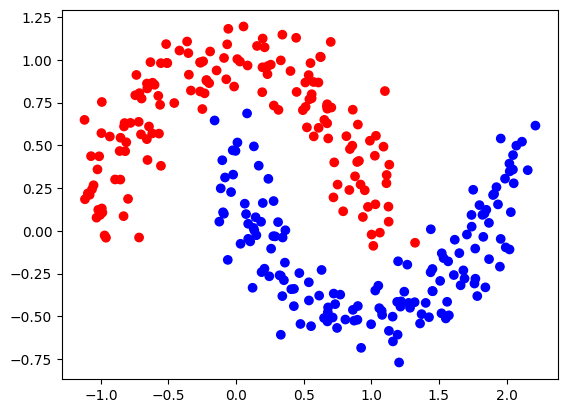

In [30]:
# A nice noisy dataset that's not linearly separable
X,y = make_moons(300, noise=0.13,random_state = random_seed)
colors = {0:'red',1:"blue"}
plt.scatter(X[:,0],X[:,1],c=np.vectorize(colors.get)(y))

### 2.3.1: Calculating Alpha

You're given some code to calculate Adaboost by hand below, but for it to work, you need to complete the following helper functions.

In `calculate_alpha`, you should calculate alpha for the round, based on the classifier's predictions and the weights of that round. The basic steps are:
1. Calculate the **weighted** error $\epsilon$ for the round by comparing those predictions to y. Remember, the error is the sum of the weights of misclassified instances.
2. Calculate alpha using the following formula:

$$\alpha = 0.5*ln(\frac{1 - \epsilon}{\epsilon})$$

In [31]:
import math
def calculate_alpha(predictions, weights, y):
    """
    Inputs:
        predictions: the predictions (0 or 1) of the classifier in this round.
        weights: the weights of each instance at the end of last round
        y: the class labels (0 or 1) for the instances
    Output: the alpha value for this round
    """
    # Calculate the weighted error
    epsilon = 0.0
    for i in range(len(y)):
        if predictions[i] != y[i]:  # If the prediction is incorrect
            epsilon += weights[i]   # Sum the weights of misclassified instances

    # Calculate alpha using the formula
    alpha = 0.5 * math.log((1 - epsilon) / epsilon)
    
    return alpha


In [34]:
# To test calculate_alpha, we need to make a decision tree and some starting weights
dt = DecisionTreeClassifier(criterion = "gini", max_depth=1, random_state=123).fit(X, y)
predictions = dt.predict(X)
weights = np.repeat(1 / len(X), len(X))
# Alpha should be ~0.84
alpha = calculate_alpha(predictions, weights, y)

0.8416209435087314

In [33]:
np.testing.assert_almost_equal(alpha, 0.8416209435087314)

### 2.3.2: Updating Weights

Next you need to write a function that will update the weights for the adaboost classifier based on the alpha value. Remember:
* Correctly classified instances have their weight decreased.
* Incorrectly classified instances have their weight increased.

The amount by which the weight changes is $e^\alpha$.

**Note**: You do not need to normalize the weights to sum to 1 - the code below will do that for you.

In [35]:
import math
def update_weights(predictions, weights, y, alpha):
    """
    Inputs:
        predictions: the predictions (0 or 1) of the classifier in this round.
        weights: the weights at the end of the previous round for each instance
        y: the class labels (0 or 1) for the instances
        alpha: the alpha value for this round
    Output: an array of updated weights for this round
    """
    updated_weights = []
    
    for i in range(len(y)):
        if predictions[i] == y[i]:  # Correct classification
            new_weight = weights[i] * math.exp(-alpha)
        else:  # Incorrect classification
            new_weight = weights[i] * math.exp(alpha)
        
        updated_weights.append(new_weight)
    
    return updated_weights


In [36]:
# Initialize the weights to 1 / n
weights = np.repeat(1 / len(X), len(X))
alpha = calculate_alpha(predictions, weights, y)
# Do one round of updating
new_weights = update_weights(predictions, weights, y, alpha) 
# See how the weights have changed for each instance - some increased, some decreased
print(new_weights)

[np.float64(0.001436704373009215), np.float64(0.001436704373009215), np.float64(0.001436704373009215), np.float64(0.001436704373009215), np.float64(0.001436704373009215), np.float64(0.001436704373009215), np.float64(0.001436704373009215), np.float64(0.001436704373009215), np.float64(0.001436704373009215), np.float64(0.007733749071730463), np.float64(0.001436704373009215), np.float64(0.007733749071730463), np.float64(0.001436704373009215), np.float64(0.001436704373009215), np.float64(0.001436704373009215), np.float64(0.001436704373009215), np.float64(0.001436704373009215), np.float64(0.001436704373009215), np.float64(0.001436704373009215), np.float64(0.007733749071730463), np.float64(0.001436704373009215), np.float64(0.001436704373009215), np.float64(0.001436704373009215), np.float64(0.001436704373009215), np.float64(0.001436704373009215), np.float64(0.001436704373009215), np.float64(0.001436704373009215), np.float64(0.001436704373009215), np.float64(0.001436704373009215), np.float64(0.

In [37]:
weights = np.repeat(1 / len(X), len(X))
# Do one round of updating
new_weights = update_weights(predictions, weights, y, alpha) 
alpha = 0.8416209435087314

In [38]:
np.testing.assert_almost_equal(max(new_weights), 1/300*math.exp(alpha))
np.testing.assert_almost_equal(min(new_weights), 1/300/math.exp(alpha))

### 2.3.3 Example: Adaboost Iteration

Here's our code for Adaboost. You don't have to modify it, just finish the functions above, and then answer the free-response question at the end.

Why are we implementing it by hand? This way we can keep track of which samples were chosen each round to visualize them.

When you run the following code, you can see the alpha values for each round, changing as the weights, and therefore the samples, change.

In [39]:
# Let's do 20 rounds of adaboost
rounds = 20
# N is the length of training data
N = len(X)
# Each boostrapped sample will b size N/5
sample_size = N // 5

# Each round, keep track of:
# Which instances (indices) were samples
sample_indices = []
# The classifier built on that sample
dtrees = []
# The alpha value for each that round
alphas = []

# Start our weights off each as 1/N
weights = np.repeat(1 / N, N)

for i in range(rounds):
    indices = np.random.choice(range(N), sample_size, replace=True, p=weights)
    sample_X = X[indices,:]
    sample_y = y[indices]
    # Train a simple decision tree on the sample
    dt = DecisionTreeClassifier(criterion = "gini", max_depth=1).fit(sample_X, sample_y)
    predictions = dt.predict(X)
    
    # Calculate alpha
    alpha = calculate_alpha(predictions, weights, y)
    print(f'Round {i} Alpha: {alpha}')
    
    # Update weights
    weights = update_weights(predictions, weights, y, alpha)
    weights /= sum(weights)
    
    sample_indices.append(indices)
    alphas.append(alpha)
    dtrees.append(dt)

Round 0 Alpha: 0.781092513791778
Round 1 Alpha: 0.6564447674348937
Round 2 Alpha: 0.5657247724019127
Round 3 Alpha: 0.6711499684200786
Round 4 Alpha: 0.221503780511708
Round 5 Alpha: 0.21928373735421258
Round 6 Alpha: 0.4358628527786772
Round 7 Alpha: 0.43381014775241017
Round 8 Alpha: 0.367255974189752
Round 9 Alpha: 0.19750552323277665
Round 10 Alpha: 0.27934829552071133
Round 11 Alpha: 0.5997773195260397
Round 12 Alpha: 0.0049634273871737855
Round 13 Alpha: 0.11759454557380654
Round 14 Alpha: 0.4573255337793062
Round 15 Alpha: 0.3407237578168403
Round 16 Alpha: 0.34486374887288956
Round 17 Alpha: 0.41246307985158664
Round 18 Alpha: 0.38357711320256005
Round 19 Alpha: 0.24868416170103208


In [40]:
# This function makes predictions for a given list of X features by taking the weighted sum of
# its constituent classifiers' predictions.
def boosting_predict(X_test):
    return np.mean([(dtrees[i].predict(X_test) - 0.5) * alphas[i] for i in range(len(dtrees))], axis=0) + 0.5

In [41]:
# Based on the image above, how should points (0, 0) and (0, 1) be classified?
# Note that the output is continuous: > 0.5 means more likely to be 1.
boosting_predict([[0, 0], [0, 1]])

array([0.5599, 0.4343])

The following code will plot the predictions from individual rounds of adaboost. Note:
* The background color indicates the prediction.
* The faded dots were *not* sampled in this round (e.g. because of their low weights).

Now we plot the first 12 rounds of adaboost:

In [42]:
# Here is a provided method that will plot the decision boundries of each stump
def plot_predictions(pred_function, sample_indices, subplot=plt, continuous=False):
    plot_colors = ["b", "r"]  
    plot_step = 0.02
    class_names = "AB"

    # Plot the decision boundaries
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = pred_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    if not continuous:
        Z = np.round(Z)
        cs = subplot.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    else:
        cs = subplot.contourf(xx, yy, Z)

    # Plot the training points
    for i, n, c in zip(range(2), class_names, plot_colors):
        idx = np.where(y == i)
        in_sample_idx = np.intersect1d(idx, sample_indices)
        subplot.scatter(X[in_sample_idx, 0], X[in_sample_idx, 1],
                        color=c, s=20, edgecolor='k', label="Class %s (Sampled)" % n)
        
        out_sample_idx = np.setdiff1d(idx, in_sample_idx)
        subplot.scatter(X[out_sample_idx, 0], X[out_sample_idx, 1],
                        color=c, s=20, edgecolor='k', alpha=0.1, label="Class %s (Not Sampled)" % n)


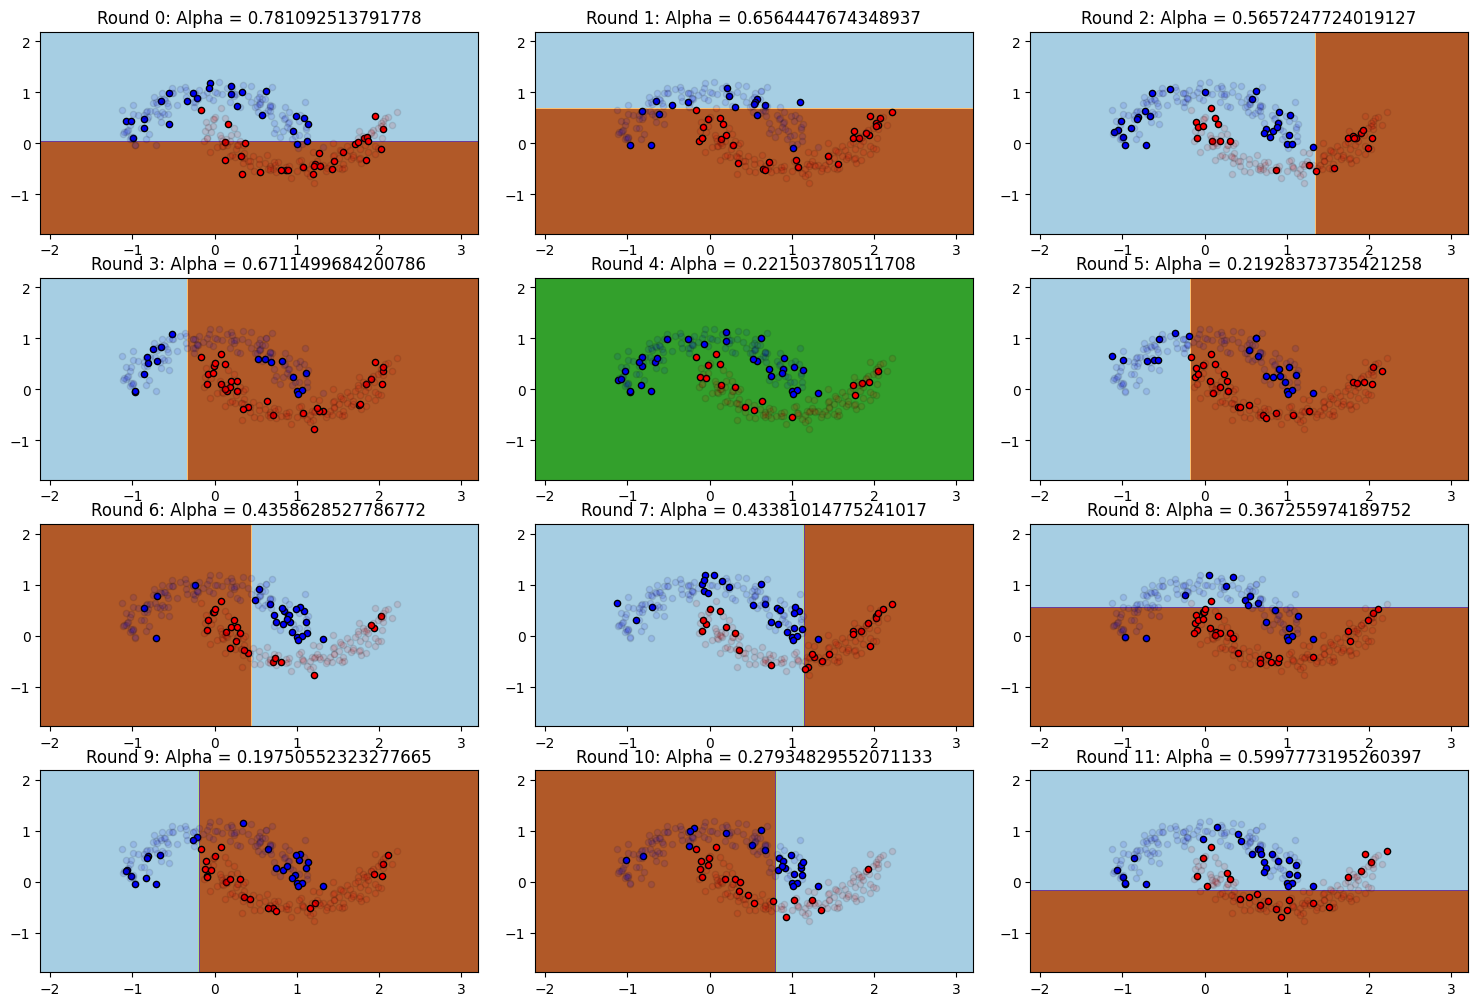

In [43]:
rows = 4
cols = 3
figure, axis = plt.subplots(rows, cols, figsize=(15, 10))
figure.tight_layout()

for i in range(rows):
    for j in range(cols):
        idx = i * cols + j  # Ensure correct indexing with cols
        plot_predictions(dtrees[idx].predict, sample_indices[idx], axis[i, j])
        axis[i, j].title.set_text(f'Round {idx}: Alpha = {alphas[idx]}')

plt.show()


Now answer the following questions:
1. Which rounds are most important to the classification? What do they have in common?
2. Do you notice any changes in the samples (and resulting classifiers) in later rounds of Adaboost?

**Answer here**
1. 
2. 

Finally, we can plot the whole adaboost classifier. Note the non-linear decision boundary.
* The first plot shows the discrete boundary, comprised of all of the above weak classifiers.
* The second plot shows the same prediction as a continuous boundary.

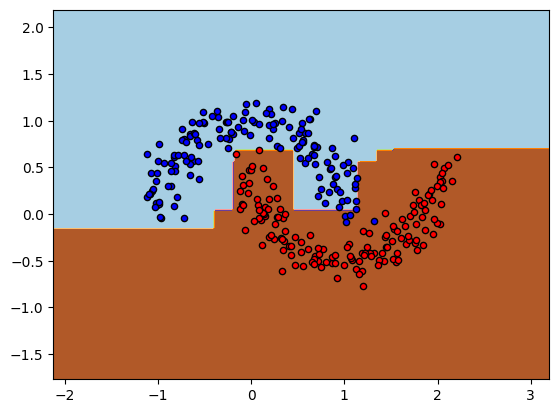

In [44]:
plot_predictions(boosting_predict, range(len(X)), plt)

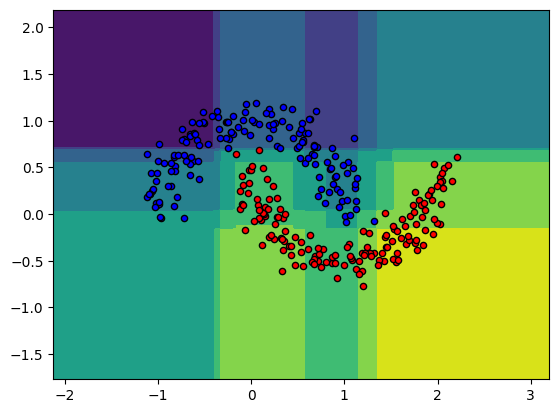

In [45]:
plot_predictions(boosting_predict, range(len(X)), plt, continuous=True)

Now answer the following questions:
1. How can Adaboost create a non-linear boundary to accurately classify this shape?
2. Which areas of the plot is the classifier most certain about, or least certain?

**Answer Here**
1. 
2. 